In [ ]:
%load_ext memory_profiler
%memit

# Chong Zhen Jie A0201613Y
---
# Assignment Question 4: Matrix Completion

In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
sns.set_theme(font_scale=1.5)
SEED = 5232

### 4(ii) Generating random matrix $Z\in\mathbb{R}^{m\times n}$

In [3]:
# Size of Z is m by n
m, n = 100, 100

# Rank of Z is r=2
r = 2

np.random.seed(SEED)
U = np.random.standard_normal(size=(m,r))
V = np.random.standard_normal(size=(n,r))
Z = U @ V.T

print(f"Size of Z: {Z.shape}")

Size of Z: (100, 100)


### 4(iii) Selecting random entries $\Omega$, where $|\Omega|=k$

In [4]:
# Define function to select the locations of k number of entries from Z
def select_entries(k, m=m, n=n):
    """
    Args:
    ===
    k: Number of random entries to select
    m: Number of rows in Z
    n: Number of columns in Z
    
    Output:
    ===
    Return Boolean masks for both observed and unobserved entries.
    """
    # Percent of entries to select
    percent = (k / (m*n)) * 100
    
    # Create Boolean mask
    rand = np.random.rand(m,n)
    mask = rand <= np.percentile(rand, percent)
    
    # Boolean mask for observed entries used in optimization, tr for train
    tr = mask
    
    #Boolean mask for unobserved entries used to compute MSE, tt for test
    tt = ~mask
    
    return tr, tt

### 4(iv) Solving the problem

##### Evaluation metric: mean-squared error (MSE)

In [5]:
# Define function to compute MSE
def compute_MSE(actual, pred, tt):
    """
    Args:
    ===
    actual: given data in the form of matrix Z
    pred: estimated X after optimization
    tt: Boolean mask of unobserved entries
    
    Output:
    ===
    Return MSE.
    """
    # Retrieve unobserved entries by indexing, and then take the difference to find an array of errors
    error = pred[tt] - actual[tt]
    # Compute MSE by formula
    MSE = np.mean(np.power(error, 2))
    
    return MSE

##### Running the solver

In [6]:
# Define function for solver
def run_solver(k, Z=Z):
    """
    Args:
    ===
    k: Number of random entries to select
    Z: given data in the form of matrix Z
    
    Output:
    ===
    Return optimal objective value and MSE.
    """
    # Generate Boolean masks, tr for solver and tt for computing MSE
    tr, tt = select_entries(k)
    
    # Construct problem and run solver
    X = cp.Variable(shape=(m,n))
    obj_fn = cp.normNuc(X)
    constraints = [ X[tr] == Z[tr] ]
    problem = cp.Problem(cp.Minimize(obj_fn), constraints)
    problem.solve()
    
    # Retrieve optimal objective value and optimal solution X
    obj, soln = problem.value, X.value
    
    # Compute MSE
    MSE = compute_MSE(Z, soln, tt)
    
    return obj, MSE

In [7]:
################################
### Around 45 minutes to run ###
################################

# Run the solver for all k = 100,200,...,3000
k_list = [i*100 for i in range(1,31)]
results = list( map(run_solver, tqdm(k_list, desc="Progress bar")) )

obj_list = [i[0] for i in results]
MSE_list = [i[1] for i in results]

Progress bar: 100%|████████████████████████████████████████████████████████████████████| 30/30 [41:02<00:00, 82.10s/it]


##### Results

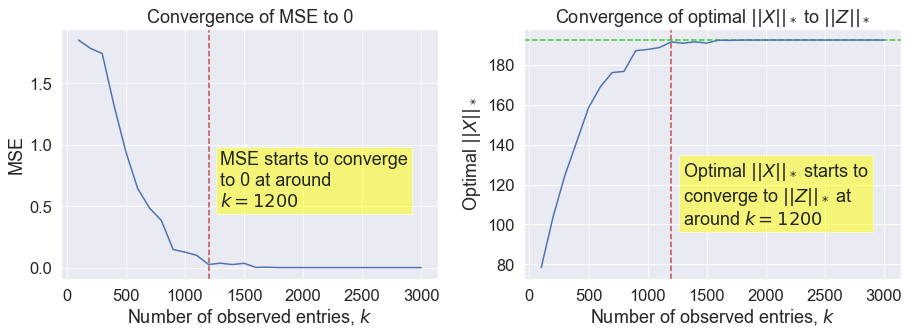

In [8]:
plt.figure(figsize=(13,5))

# MSE against r
plt.subplot(1,2,1)
plt.plot(k_list, MSE_list)
plt.axvline(1200, ls="--", c="r")
plt.text(1200+100, 0.5,
         s="MSE starts to converge\nto 0 at around\n$k=1200$",
         bbox=dict(facecolor="yellow",alpha=0.5))
plt.xlabel("Number of observed entries, $k$")
plt.ylabel("MSE")
plt.title("Convergence of MSE to 0")

# Nuclear norm of Z
nuc_Z = np.linalg.norm(Z, ord="nuc")

# Objective value against r
plt.subplot(1,2,2)
plt.axvline(1200, ls="--", c="r")
plt.axhline(nuc_Z, ls="--", c="limegreen")
plt.plot(k_list, obj_list)
plt.text(1200+100, 100,
         s="Optimal $||X||_*$ starts to\nconverge to $||Z||_*$ at\naround $k=1200$",
         bbox=dict(facecolor="yellow",alpha=0.5))
plt.xlabel("Number of observed entries, $k$")
plt.ylabel("Optimal $||X||_*$")
plt.title("Convergence of optimal $||X||_*$ to $||Z||_*$")

plt.tight_layout()
plt.show()

---